## For a whole day, find multi-modal decode time, and plot all examples

Relevent python file:
`RemoteTimes.py`

Relevent tables and operations: 

From `TrialChoice` parse trial start end time, then 

(1) find when mean decode is in another arm.
(2) Chop by cont/frag state
(3) Classify decode in each chopped time window.

The results are in `TrialChoiceDispersedReplay`.

In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_task import TaskEpoch

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
#from spyglass.decoding.clusterless import (UnitMarks,
#                                           UnitMarkParameters,UnitMarksIndicatorSelection,
#                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.RemoteTimes import cal_arm_posterior,find_dispersed_time
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,EpochPos,
                                   TrialChoiceReplay,TrialChoiceRemoteReplay,
                                   RippleTimes,TrialChoiceDispersedReplay,
                                   Decode,get_linearization_map,
                                   find_ripple_times,find_remote_times,mua_thresholder,
                                   segment_ripples,sort_replays,select_subset,
                                   classify_ripples,classify_ripple_content,plot_decode_spiking,
                                  )
from spyglass.shijiegu.helpers import interpolate_to_new_time,find_trial_id,mergeIntervals 
from spyglass.shijiegu.load import load_epoch_data
from spyglass.shijiegu.SessionData import SessionData
from ripple_detection.core import get_envelope


In [18]:
import os
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [19]:
# the only cell to be edited
nwb_file_name = 'eliot20221024.nwb'

In [20]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward pandas dataframe, choice"
eliot20221024_.nwb,2,02_Seq2Session2,=BLOB=
eliot20221024_.nwb,4,04_Seq2Session3,=BLOB=
eliot20221024_.nwb,6,06_Seq2Session4,=BLOB=
eliot20221024_.nwb,8,08_Seq2Session5,=BLOB=
eliot20221024_.nwb,10,10_Seq2Session6,=BLOB=


In [21]:
IntervalPositionInfo & {'nwb_file_name':nwb_copy_file_name}

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,analysis_file_name name of the file,head_position_object_id,head_orientation_object_id,head_velocity_object_id
default,eliot20221024_.nwb,pos 1 valid times,eliot20221024_LF7XXXC7WS.nwb,5f4c05bc-09e0-4af6-b9ce-1853c0378933,39f34be9-87dd-40f7-8985-575158974af1,fee7cfb9-5f42-46a0-be2c-6ba72482b9b8
default,eliot20221024_.nwb,pos 3 valid times,eliot20221024_CQHVC8W9YO.nwb,6e0ac1ac-4fc1-4454-8a8a-2ab73c36ac4c,a67d7101-6868-4adc-883f-e4499facee3f,93f580d5-7a23-4b2e-933d-da3b06dbc9f3
default,eliot20221024_.nwb,pos 5 valid times,eliot20221024_B15OP7T247.nwb,1acfaea2-f173-483a-989b-3aa16ce781fe,27502dd2-8df0-4a85-978a-6b297055bdf0,d361dba4-eae6-4936-900b-acf5ef81f934
default,eliot20221024_.nwb,pos 7 valid times,eliot20221024_BAM28O6YJQ.nwb,9557c422-1266-4572-a55d-9fb6de1252eb,b8a6438e-b562-4aea-98b3-36cc32f1e925,4ae7523f-5241-4c12-b6ad-35e6b65ea3a5
default,eliot20221024_.nwb,pos 9 valid times,eliot20221024_M4OYYYOYFK.nwb,3374d1ac-491d-42c8-b7e0-f62244ab137c,ea254f5f-6543-458f-8fec-de56cc764d11,0c18d0d5-8882-45db-b3c4-23da3fccf7e1
default_decoding,eliot20221024_.nwb,pos 1 valid times,eliot20221024_4V68CJ354Y.nwb,0e5e9085-d03e-4717-94a9-01b85e6612fb,e1a81f59-5bd9-4ea1-9ce3-5f52fd78154a,cd26f0d1-1979-4097-b4c5-a5ba9a92b284
default_decoding,eliot20221024_.nwb,pos 3 valid times,eliot20221024_JLWSZX0624.nwb,e6e0f5fa-2afa-4f2f-9a5e-a8d25126fa66,31b0512e-1c20-400a-8b5f-4363ecea5a20,a0b7b6cd-6997-4e37-b068-a06fc6f8bb8b
default_decoding,eliot20221024_.nwb,pos 5 valid times,eliot20221024_F4HREIXIXV.nwb,9720500c-aca3-475c-840b-42a4b8ab7a06,fd94b2f0-d64a-4ff0-af16-b1aa43653e06,b2774973-c1ca-4306-ac1a-4836af7ceb13
default_decoding,eliot20221024_.nwb,pos 7 valid times,eliot20221024_SQOPQJWA0K.nwb,37243f1c-8494-47a8-ad2f-6f67d5f9b935,81110d59-917d-4e02-838a-33ac35f98b23,bcf34ace-64a7-4caa-a2cd-77ddd14160b0
default_decoding,eliot20221024_.nwb,pos 9 valid times,eliot20221024_VV4225334V.nwb,540c2f23-6394-4ea7-87ad-9d123cfc295a,a3bba802-fd1c-4e60-87a9-31f176cbe65e,45b25961-d6e0-4319-aa57-f6432d7888cf


In [22]:
# select position timestamps, only maze sessions are selected
IntervalList_pd=pd.DataFrame(TaskEpoch & {'nwb_file_name': nwb_copy_file_name})
position_interval=[]
session_interval=[]
epochs=[]
for i in IntervalList_pd.index:
    epoch=IntervalList_pd['epoch'][i]
    interval=IntervalList_pd['interval_list_name'][i]
    if ('Session' in interval) and ('Hz' not in interval and 'hippocampus' not in interval):
        epochs.append(epoch)
        session_interval.append(interval)
        
        epoch_number=int(interval[:2])
        pos_interval='pos '+str(epoch_number-1)+' valid times'
        position_interval.append(pos_interval)
        
        # insert into decode
        key={'nwb_file_name':nwb_copy_file_name,
             'epoch':epoch,
             'epoch_name':interval,
             'position_interval':pos_interval}
        EpochPos().insert1(key,replace=True)
print(epochs)
print(session_interval)
print(position_interval)

[2, 4, 6, 8, 10]
['02_Seq2Session2', '04_Seq2Session3', '06_Seq2Session4', '08_Seq2Session5', '10_Seq2Session6']
['pos 1 valid times', 'pos 3 valid times', 'pos 5 valid times', 'pos 7 valid times', 'pos 9 valid times']


In [23]:
EpochPos() & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),epoch_name TaskEpoch or IntervalList,position_interval IntervalPositionInfo
eliot20221024_.nwb,2,02_Seq2Session2,pos 1 valid times
eliot20221024_.nwb,4,04_Seq2Session3,pos 3 valid times
eliot20221024_.nwb,6,06_Seq2Session4,pos 5 valid times
eliot20221024_.nwb,8,08_Seq2Session5,pos 7 valid times
eliot20221024_.nwb,10,10_Seq2Session6,pos 9 valid times


In [24]:
offset=0.5

seg2arm={}
seg2arm[0]=0
for i in range(1,6):
    seg2arm[i]=5
seg2arm[6]=1
seg2arm[7]=2
seg2arm[8]=3
seg2arm[9]=4

arm2seg={}
arm2seg[1]=6
arm2seg[2]=7
arm2seg[3]=8
arm2seg[4]=9

### Debug Start

In [25]:
(epoch_name,log_df,
     decode,
     head_speed,head_orientation,linear_position_df,
     theta_df,
     ripple_df,
     neural_df,mua_df,recordings)=load_epoch_data(nwb_copy_file_name,2)

[2023-07-12 13:31:41,775][WARNING]: Skipped checksum for file with hash: b1d911d3-995a-36c1-2c37-80f2fea1ae67, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_LF7XXXC7WS.nwb
12-Jul-23 13:31:41 Skipped checksum for file with hash: b1d911d3-995a-36c1-2c37-80f2fea1ae67, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_LF7XXXC7WS.nwb


epoch name 02_Seq2Session2
epoch_pos_name pos 1 valid times


[2023-07-12 13:31:42,021][WARNING]: Skipped checksum for file with hash: 9533fdd3-5c9b-befb-528b-5f9078370699, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_5U6AA74W1Z.nwb
12-Jul-23 13:31:42 Skipped checksum for file with hash: 9533fdd3-5c9b-befb-528b-5f9078370699, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_5U6AA74W1Z.nwb
[2023-07-12 13:31:42,453][WARNING]: Skipped checksum for file with hash: 893403b0-5045-7c15-0912-7b874f384dbe, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_PDFPHDFHVW.nwb
12-Jul-23 13:31:42 Skipped checksum for file with hash: 893403b0-5045-7c15-0912-7b874f384dbe, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_PDFPHDFHVW.nwb
[2023-07-12 13:31:43,347][WARNING]: Skipped checksum for file with hash: ca11d2c9-268b-5769-314e-155c275745a8, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_IGTFG6YOGR.nwb
12-Jul-23 13:31:43 Skipped checksum for file with hash: ca11d2c9-268b-5769-314e-155c275745a8, and path: /stel

In [174]:
# find tetrodes
groups_with_cell=(SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

In [177]:
groups_with_cell

array([ 0,  2,  4,  5, 13, 14, 16, 17, 20, 26, 27, 28, 29, 30, 31])

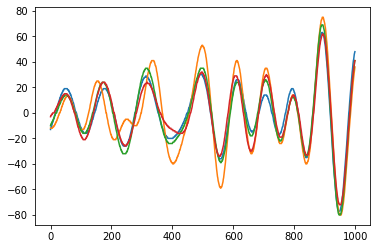

In [189]:
plt.plot(np.array(theta_df[4])[1000:2000])
plt.plot(np.array(theta_df[5])[1000:2000])
plt.plot(np.array(theta_df[6])[1000:2000])
plt.plot(np.array(theta_df[7])[1000:2000])

In [157]:
        t=68
        print(t)
        home_t=log_df.loc[t,'timestamp_H']
        if np.isnan(home_t):
            home_t=log_df.loc[t,'timestamp_O']-3
            
        outer_t=log_df.loc[t,'timestamp_O']+5
        if t+1<=np.max(trials):
            if ~np.isnan(log_df.loc[t+1,'timestamp_H']):
                outer_t=np.max([outer_t,log_df.loc[t+1,'timestamp_H']])
        
        # find the time when the animal is still on the same segment
        pos_subset=linear_position_df.sel(time=linear_position_df.time[
            np.logical_and(linear_position_df.time>=home_t,linear_position_df.time<=outer_t)])
        if ~np.isnan(log_df.loc[t,'OuterWellIndex']):
            pos_subset_track=pos_subset.where(
                pos_subset.track_segment_id == arm2seg[int(log_df.loc[t,'OuterWellIndex'])] , drop=True)
            outer_t=float(pos_subset_track.time[-1])

        # load small snippet of decode
        time_slice=slice(home_t,outer_t)
        posterior=decode.sel(time=time_slice).acausal_posterior

        # find dispersed time
        (times,multimodal_xr,
         posterior_arm_subsets,posterior_armsIDs) = find_dispersed_time(posterior)

68


In [167]:
home_t=log_df.loc[71,'timestamp_O']
home_t

1666636360.6624978

In [168]:
home_t=log_df.loc[71,'timestamp_O']-8
outer_t=log_df.loc[71,'timestamp_O']-5

#home_t=times[0][0]-0.5
#outer_t=times[0][1]+0.5

# load small snippet of decode
time_slice=slice(home_t,outer_t)
posterior=decode.sel(time=time_slice).acausal_posterior

In [159]:
# find dispersed time
(times,multimodal_xr,
posterior_arm_subsets,posterior_armsIDs) = find_dispersed_time(posterior)

In [169]:
from scipy.stats import entropy
from skimage.morphology import area_closing,remove_small_holes

#times=[]
posterior_arm_subsets=[]
posterior_armsIDs=[]
    
# posterior of arm by summing out the state variable
posterior_position=posterior.sum(dim='state')
posterior_state=posterior.sum(dim='position')
    
# lump by arms
posterior_arms,posterior_arms_entropy=cal_arm_posterior(posterior_position)
    
# find dispersed time windows through entropy
H = entropy(posterior_arms,axis=0)

In [170]:
f2=(np.sum((posterior_arms[0:5,:]>=0.16).astype(int),axis=0)>=2).astype(int)
f3=(np.sum((posterior_arms_entropy[0:5,:]<=3).astype(int),axis=0)>=2).astype(int)
f=f2+f3>=2 #both conditions are met
f2_closed = area_closing(1-f, 10, connectivity=1) #close small 1's, decode is done at 500 Hz, 2 ms, fullfilling requirement 2

In [347]:
from skimage import measure

f=H>=0.8
f_closed = area_closing(1-f, 10, connectivity=1) #close small 1's, decode is done at 1000 Hz, 1 ms, fullfilling requirement 2
c_labels,c_num = measure.label(1-f_closed,return_num=True)

eligible_c=[]
ineligible_c=[]

In [348]:
    for c in range(1,c_num+1):
        c_ind=np.argwhere(c_labels==c).ravel()
        c_start=np.array(posterior.time[c_ind[0]])
        c_end=np.array(posterior.time[c_ind[-1]])
        posterior_state_mean=posterior_state.sel(time=slice(c_start,c_end)).mean(dim='time')
        cont_mean=np.array(posterior_state_mean.sel(state='Continuous'))
        if cont_mean>0.5:
            eligible_c.append(c)
        else:
            ineligible_c.append(c)

In [342]:
eligible_c

[1, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16]

In [357]:
c=10
c_ind=np.argwhere(c_labels==c).ravel()
c_start=np.array(posterior.time[c_ind[0]])
c_end=np.array(posterior.time[c_ind[-1]])
        
# lump posterior by arm for requirement 4 (at least two segments)
posterior_position_subset=posterior_position.sel(time=slice(c_start,c_end))
posterior_arms_subset=cal_arm_posterior(posterior_position_subset)
f2=np.sum((posterior_arms_subset[1:5,:]>=0.2).astype(int),axis=0)>=2
f2_closed = area_closing(1-f2, 10, connectivity=1) #close small 1's, decode is done at 1000 Hz, 1 ms, fullfilling requirement 2
c2_labels,c2_num = measure.label(1-f2_closed,return_num=True)

In [496]:
# load small snippet of decode
time_slice=slice(home_t,outer_t)
posterior=decode.sel(time=time_slice).acausal_posterior
posterior_position=posterior.sum(dim='state')

In [502]:
posterior_arms,posterior_arms_entropy=cal_arm_posterior(posterior_position)

In [147]:
f2=(np.sum((posterior_arms[1:5,:]>=0.16).astype(int),axis=0)>=2).astype(int)
f3=(np.sum((posterior_arms_entropy[1:5,:]<=3).astype(int),axis=0)>=2).astype(int)
f=(f2+f3)>=2 #both conditions are met
    
f2_closed = area_closing(1-f, 10, connectivity=1) #close small 1's, decode is done at 500 Hz, 2 ms, fullfilling requirement 2
c_labels,c_num = measure.label(1-f2_closed,return_num=True)
    
eligible_c=[]
ineligible_c=[]

NameError: name 'measure' is not defined

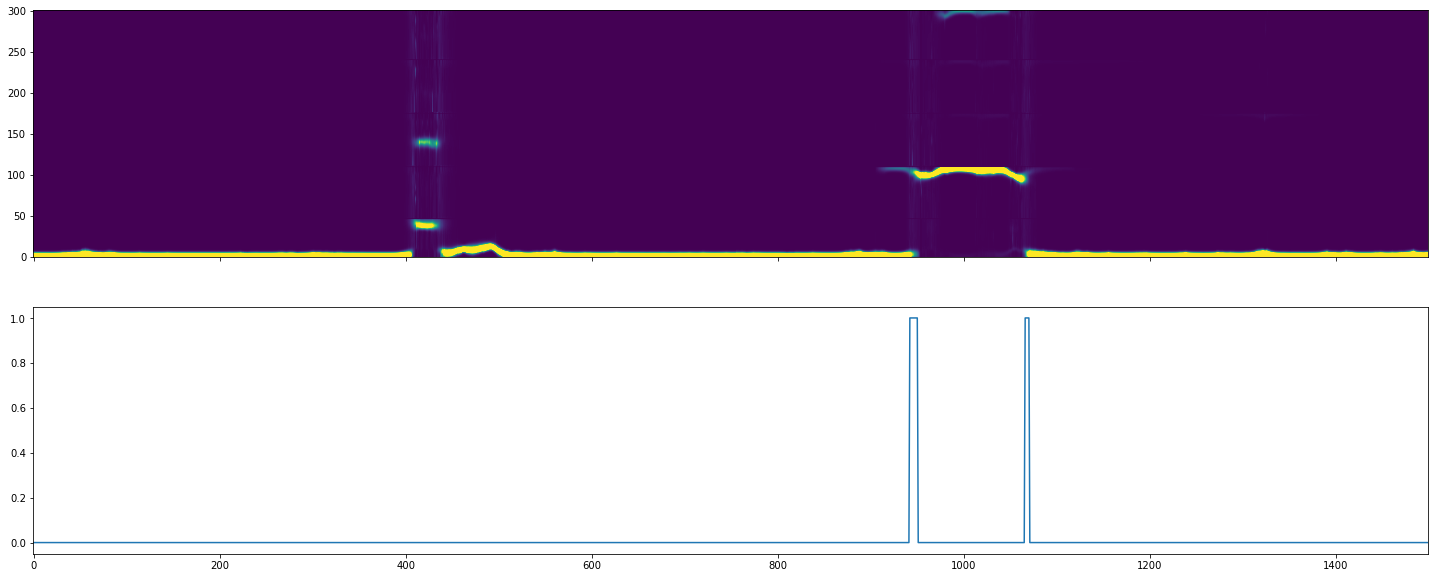

In [172]:
posterior_position=posterior.sum(dim='state')

fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(25,10),sharex=True)
axes[0].imshow(posterior_position.T,vmin=0,vmax=0.05,origin='lower')
axes[0].set_aspect('auto')

axes[1].plot(f2)
axes[1].plot(f3)
axes[1].plot(f)

#axes[1].plot(H)
#axes[1].plot(np.array(multimodal_xr.multimodal_flag))


In [498]:
linear_map,node_location=get_linearization_map()
arm_start_end={}
arm_start_end[0]=linear_map[0]
arm_start_end[1]=linear_map[3]
arm_start_end[2]=linear_map[5]
arm_start_end[3]=linear_map[7]
arm_start_end[4]=linear_map[9]

In [499]:
# sum of posterior for an arm for each time bin and entropy within each arm
posterior_arms_entropy=np.zeros((6,posterior_position.shape[0])) #posterior_position.shape[0] is time bin number
for arm_id in [0,1,2,3,4]:
    position_slice=slice(arm_start_end[arm_id][0],arm_start_end[arm_id][1])
    posterior_arms_entropy[arm_id,:]=entropy(posterior_position.sel(position=position_slice),axis=1)

In [473]:
arm_id=1
position_slice=slice(arm_start_end[arm_id][0],arm_start_end[arm_id][1])
posterior_position_arm=decode.sel(position=position_slice).sum(dim='state')

In [485]:
np.logical_and(np.array([1,1,0])>0,np.array([0,1,0])>0)

array([False,  True, False])

(array([2.20000e+01, 1.48000e+02, 5.24000e+02, 8.53000e+02, 8.66000e+02,
        1.81090e+04, 2.31170e+04, 1.50780e+04, 1.48920e+04, 1.72270e+04,
        1.74950e+04, 1.44580e+04, 1.00520e+04, 9.33300e+03, 1.14800e+04,
        1.73920e+04, 2.70540e+04, 5.02480e+04, 1.32182e+05, 4.82710e+05]),
 array([0.84082586, 0.9879941 , 1.1351622 , 1.2823305 , 1.4294987 ,
        1.576667  , 1.7238351 , 1.8710034 , 2.0181715 , 2.1653397 ,
        2.312508  , 2.4596763 , 2.6068444 , 2.7540126 , 2.901181  ,
        3.0483491 , 3.1955173 , 3.3426855 , 3.4898539 , 3.637022  ,
        3.7841902 ], dtype=float32),
 <BarContainer object of 20 artists>)

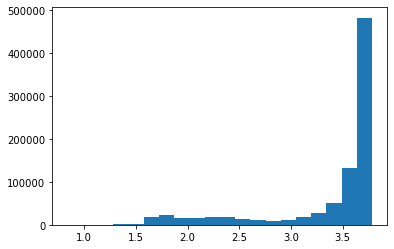

In [483]:
plt.hist(entropy(posterior_position_arm.acausal_posterior,axis=1),bins=20)

In [470]:
print(entropy(np.ones(29)),entropy(np.ones(43)))

3.367295829986473 3.7612001156935624


In [417]:
posterior_position.max(axis=1)

<xarray.DataArray 'acausal_posterior' (time: 10953)>
array([0.16043451, 0.15768781, 0.15530801, ..., 0.10553037, 0.10273898,
       0.09997986], dtype=float32)
Coordinates:
  * time     (time) float64 1.667e+09 1.667e+09 ... 1.667e+09 1.667e+09

In [349]:
    eligible_c_copy = eligible_c.copy()
    ineligible_c_copy = ineligible_c.copy()
    
    for c in eligible_c: #eligible for now!
        print('c',c)
        c_ind=np.argwhere(c_labels==c).ravel()
        c_start=np.array(posterior.time[c_ind[0]])
        c_end=np.array(posterior.time[c_ind[-1]])
        
        # lump posterior by arm for requirement 4 (at least two segments)
        posterior_position_subset=posterior_position.sel(time=slice(c_start,c_end))
        posterior_arms_subset=cal_arm_posterior(posterior_position_subset)
        f2=np.sum((posterior_arms_subset[1:5,:]>=0.1).astype(int),axis=0)>=2
        f2_closed = area_closing(1-f2, 10, connectivity=1) #close small 1's, decode is done at 1000 Hz, 1 ms, fullfilling requirement 2
        c2_labels,c2_num = measure.label(1-f2_closed,return_num=True)
        
        if c2_num>0:
            
            
            posterior_armsID = np.argwhere(
                np.mean(posterior_arms_subset[:,c2_labels>=1],axis=1)[:5]>=0.1)
            
            print('new event added')
            posterior_arm_subset_pd = pd.DataFrame({'home':posterior_arms_subset[0,:],
                                                    'arm1':posterior_arms_subset[1,:],
                                                    'arm2':posterior_arms_subset[2,:],
                                                    'arm3':posterior_arms_subset[3,:],
                                                    'arm4':posterior_arms_subset[4,:],
                                                    'center':posterior_arms_subset[5,:]}, index=np.array(posterior_position_subset.time))
            posterior_arm_subset_pd.index.name='time'
            posterior_arm_subset=xr.Dataset.from_dataframe(posterior_arm_subset_pd)
            
            posterior_arm_subsets.append(posterior_arm_subset)
            times.append([c_start,c_end])
            posterior_armsIDs.append(posterior_armsID)
        else:
            eligible_c_copy.remove(c)
            ineligible_c_copy.append(c)
    eligible_c=eligible_c_copy.copy()
    ineligible_c=ineligible_c_copy.copy()

c 1
c 4
c 5
c 7
c 8
new event added
c 10
new event added
c 11
c 12
c 13
c 14
new event added
c 15
c 16


In [338]:
eligible_c

[1, 4, 5, 7, 8, 10, 12, 13, 14, 15, 16]

In [317]:
c_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0])

In [285]:
float(times[3][0])

1666634925.4102235

In [237]:
float(times[1][0])

1666634921.944224

In [303]:
c=15;
c_ind=np.argwhere(c_labels==c).ravel()
c_start=np.array(posterior.time[c_ind[0]])
c_end=np.array(posterior.time[c_ind[-1]])

posterior_position_subset=posterior_position.sel(time=slice(c_start,c_end))
posterior_arms_subset=cal_arm_posterior(posterior_position_subset)
posterior_arm_mean=np.mean(posterior_arms_subset,axis=1)[:5]
posterior_armsID=np.argwhere(posterior_arm_mean>=0.1)
        
posterior_armsID_nohome=np.argwhere(posterior_arm_mean[1:]>=0.1).ravel()

In [304]:
posterior_armsID

array([[0],
       [2],
       [3],
       [4]])

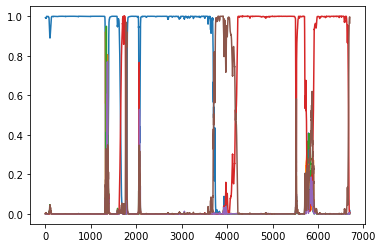

In [409]:
plt.plot(posterior_arms.T);

In [213]:
for c in ineligible_c:
    c_labels[c_labels==c]=0

multimodal_flag=c_labels>=1
multimodal_df = pd.DataFrame({'multimodal_flag':multimodal_flag}, index=np.array(posterior.time))
multimodal_df.index.name='time'
multimodal_xr=xr.Dataset.from_dataframe(multimodal_df)

In [214]:
times

[[array(1.66663492e+09), array(1.66663492e+09)],
 [array(1.66663492e+09), array(1.66663492e+09)],
 [array(1.66663492e+09), array(1.66663492e+09)],
 [array(1.66663492e+09), array(1.66663492e+09)]]

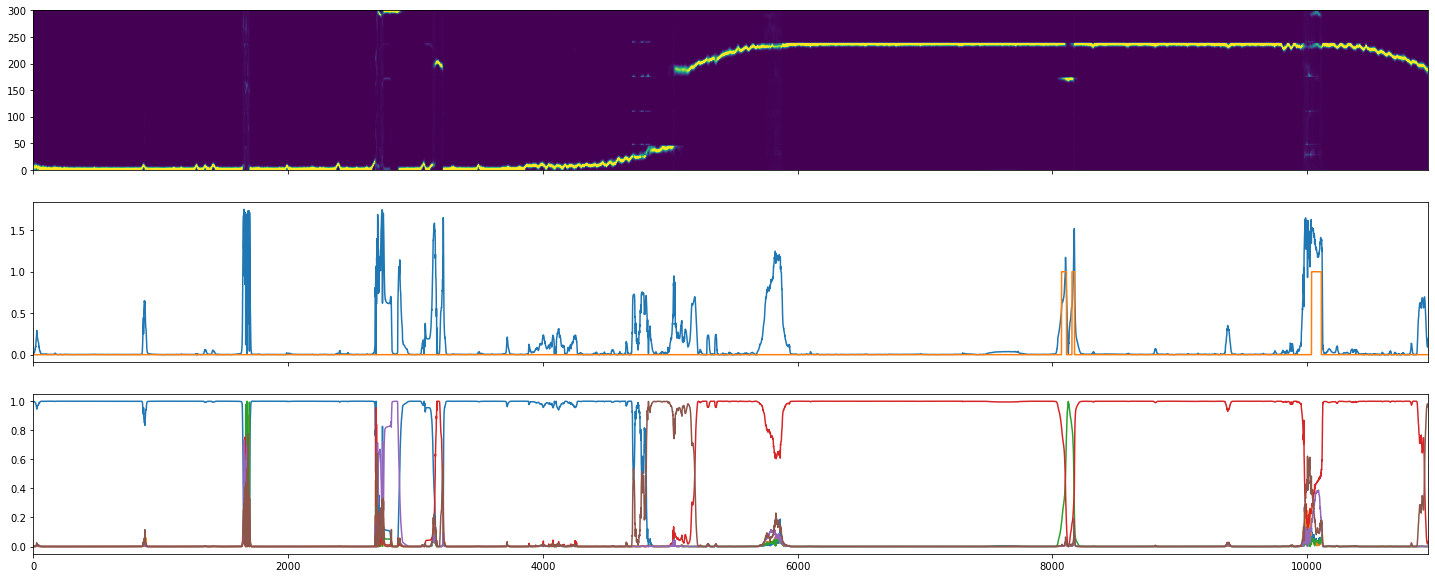

In [415]:
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(25,10),sharex=True)
axes[0].imshow(posterior_position.T,vmax=0.1,origin='lower')
axes[0].set_aspect('auto')

#axes[1].plot(f1)
axes[1].plot(H)
#axes[1].plot(c_labels)
axes[1].plot(np.array(multimodal_xr.multimodal_flag))

#axes[1].plot(f_closed)
#plt.plot(all_labels,'*')

axes[2].plot(posterior_arms.T)
#axes[2].plot(posterior_arms.T)

In [420]:
t=30;
home_t=log_df.loc[t,'timestamp_H']
if np.isnan(home_t):
    home_t=log_df.loc[t,'timestamp_O']-3
            
outer_t=log_df.loc[t,'timestamp_O']+5
if t+1<=np.max(trials):
    if ~np.isnan(log_df.loc[t+1,'timestamp_H']):
        outer_t=np.max([outer_t,log_df.loc[t+1,'timestamp_H']])
        
# find the time when the animal is still on the same segment
pos_subset=linear_position_df.sel(time=linear_position_df.time[
    np.logical_and(linear_position_df.time>=home_t,linear_position_df.time<=outer_t)])
pos_subset_track=pos_subset.where(
    pos_subset.track_segment_id == arm2seg[int(log_df.loc[t,'OuterWellIndex'])] , drop=True)
outer_t=float(pos_subset_track.time[-1])

1666634927.4702232


In [149]:
for c in np.arange(np.shape(times)[0]):
    (c_start,c_end)=[] #(times[c][0],times[c][1])
    mua_event=np.array((mua_df.sel(time=mua_df.time[np.logical_and(mua_df.time>=c_start,mua_df.time<=c_end)])).mean().to_array())
    print(mua_event<mua_threshold)

[False]


In [520]:
t=30

home_t=log_df.loc[t,'timestamp_H']
if np.isnan(home_t):
    home_t=log_df.loc[t,'timestamp_O']-3
            
outer_t=log_df.loc[t,'timestamp_O']+5
if t+1<=np.max(trials):
    if ~np.isnan(log_df.loc[t+1,'timestamp_H']):
        outer_t=np.max([outer_t,log_df.loc[t+1,'timestamp_H']])
        
pos_subset=linear_position_df.sel(time=linear_position_df.time[
    np.logical_and(linear_position_df.time>=home_t,linear_position_df.time<=outer_t)])
if ~np.isnan(log_df.loc[t,'OuterWellIndex']):
    pos_subset_track=pos_subset.where(
        pos_subset.track_segment_id == arm2seg[int(log_df.loc[t,'OuterWellIndex'])] , drop=True)
    outer_t=float(pos_subset_track.time[-1])

In [526]:
# load small snippet of decode
time_slice=slice(home_t,outer_t)
posterior=decode.sel(time=time_slice).acausal_posterior

# find dispersed time
(times,multimodal_xr,
    posterior_arm_subsets,posterior_armsIDs) = find_dispersed_time(posterior)
        
print(times)

for c in np.arange(np.shape(times)[0]):
    (c_start,c_end)=(times[c][0],times[c][1])

    # check mua criteria, the final requirement
            
    mua_event=np.array((mua_df.sel(time=mua_df.time[np.logical_and(mua_df.time>=c_start,mua_df.time<=c_end)])).median().to_array())
    print(mua_event)
    print(mua_threshold)
    print(mua_event<mua_threshold)

[[1.66663549e+09 1.66663549e+09]
 [1.66663549e+09 1.66663549e+09]
 [1.66663549e+09 1.66663549e+09]]
[8.62488104]
[37.54983413]
[ True]
[22.48344931]
[37.54983413]
[ True]
[44.57218132]
[37.54983413]
[False]


In [30]:
c=0
(c_start,c_end)=(times[c][0],times[c][1])

# check mua criteria, the final requirement
            
mua_event=np.array((mua_df.sel(time=mua_df.time[np.logical_and(mua_df.time>=c_start,mua_df.time<=c_end)])).median().to_array())
print(mua_event)

[32.8684349]


In [31]:
print(mua_threshold)

[37.54983413]


In [525]:
mua_threshold=np.array(mua_df.median().to_array())

### Debug End

[2023-07-12 15:00:51,719][WARNING]: Skipped checksum for file with hash: b1d911d3-995a-36c1-2c37-80f2fea1ae67, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_LF7XXXC7WS.nwb
12-Jul-23 15:00:51 Skipped checksum for file with hash: b1d911d3-995a-36c1-2c37-80f2fea1ae67, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_LF7XXXC7WS.nwb
[2023-07-12 15:00:51,741][WARNING]: Skipped checksum for file with hash: 9533fdd3-5c9b-befb-528b-5f9078370699, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_5U6AA74W1Z.nwb
12-Jul-23 15:00:51 Skipped checksum for file with hash: 9533fdd3-5c9b-befb-528b-5f9078370699, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_5U6AA74W1Z.nwb
[2023-07-12 15:00:51,860][WARNING]: Skipped checksum for file with hash: 893403b0-5045-7c15-0912-7b874f384dbe, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_PDFPHDFHVW.nwb
12-Jul-23 15:00:51 Skipped checksum for file with hash: 893403b0-5045-7c15-0912-7b874f384dbe, and path: /stel

epoch name 02_Seq2Session2
epoch_pos_name pos 1 valid times


[2023-07-12 15:00:52,246][WARNING]: Skipped checksum for file with hash: ca11d2c9-268b-5769-314e-155c275745a8, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_IGTFG6YOGR.nwb
12-Jul-23 15:00:52 Skipped checksum for file with hash: ca11d2c9-268b-5769-314e-155c275745a8, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_IGTFG6YOGR.nwb


66
[[1.66663624e+09 1.66663624e+09]
 [1.66663624e+09 1.66663624e+09]
 [1.66663625e+09 1.66663625e+09]
 [1.66663625e+09 1.66663625e+09]]
less than MUA threshold
[5.69168921]
less than MUA threshold
[3.91949504]
here
less than MUA threshold
[10.51285288]


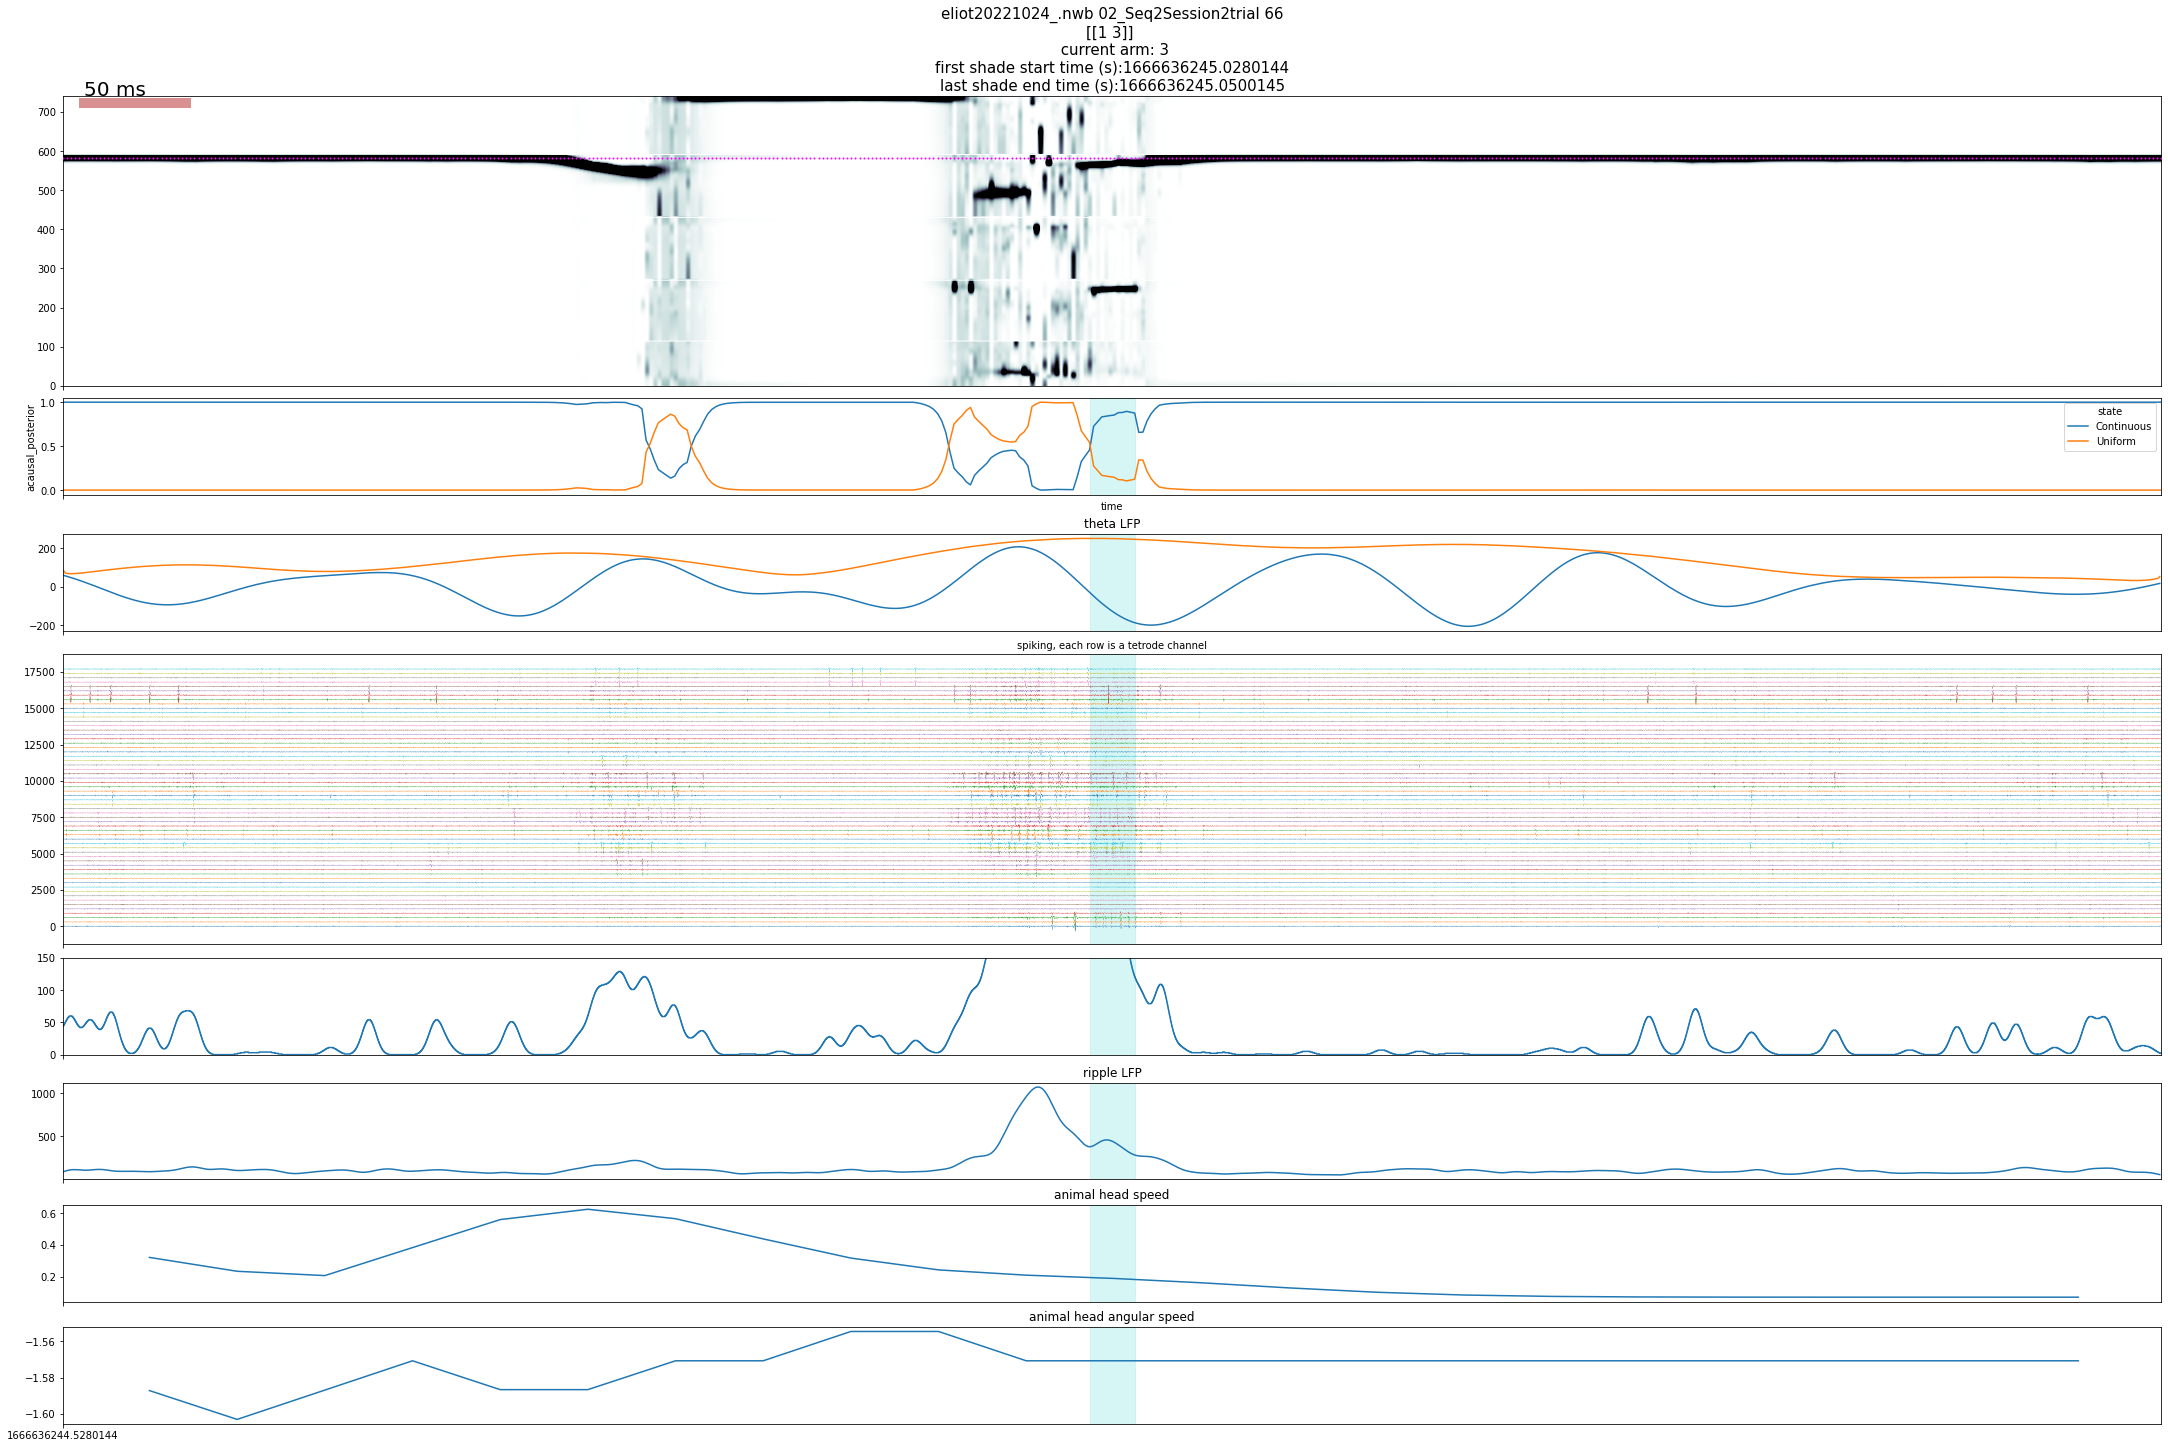

In [127]:
epochs=(EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')

for epoch_num in [2]:#epochs:
    (epoch_name,log_df,
     decode,
     head_speed,head_orientation,linear_position_df,
     theta_df,
     ripple_df,
     neural_df,mua_df,recordings)=load_epoch_data(nwb_copy_file_name,epoch_num)
    
    # MUA threshold
    mua_threshold=np.array(mua_df.median().to_array())
    '''
    # if only movement data goes into threshold calculation
    head_speed_upsample = xr.Dataset.from_dataframe(interpolate_to_new_time(head_speed.to_dataframe(), np.array(mua_df.time)))
    mua_df.sel(time=head_speed_upsample.where(head_speed_upsample.head_speed>=4,drop=True).time).median()
    '''
    
    trials=np.array(log_df.index)
    log_df['dispersed_times']=[[] for t in trials]

    for t in [66]:#trials:
        print(t)
        home_t=log_df.loc[t,'timestamp_H']
        if np.isnan(home_t):
            home_t=log_df.loc[t,'timestamp_O']-3
            
        outer_t=log_df.loc[t,'timestamp_O']+5
        if t+1<=np.max(trials):
            if ~np.isnan(log_df.loc[t+1,'timestamp_H']):
                outer_t=np.max([outer_t,log_df.loc[t+1,'timestamp_H']])
        
        # find the time when the animal is still on the same segment
        pos_subset=linear_position_df.sel(time=linear_position_df.time[
            np.logical_and(linear_position_df.time>=home_t,linear_position_df.time<=outer_t)])
        if ~np.isnan(log_df.loc[t,'OuterWellIndex']):
            pos_subset_track=pos_subset.where(
                pos_subset.track_segment_id == arm2seg[int(log_df.loc[t,'OuterWellIndex'])] , drop=True)
            outer_t=float(pos_subset_track.time[-1])

        # load small snippet of decode
        time_slice=slice(home_t,outer_t)
        posterior=decode.sel(time=time_slice).acausal_posterior

        # find dispersed time
        (times,multimodal_xr,
         posterior_arm_subsets,posterior_armsIDs) = find_dispersed_time(posterior)
        
        print(times)

        for c in np.arange(np.shape(times)[0]):
            (c_start,c_end)=(times[c][0],times[c][1])

            # check mua criteria, the final requirement
            
            mua_event=np.array((mua_df.sel(time=mua_df.time[np.logical_and(mua_df.time>=c_start,mua_df.time<=c_end)])).median().to_array())
            if mua_event<mua_threshold:
                print('less than MUA threshold')
                print(mua_event)
                continue

            time_slice=slice(c_start-offset,c_end+offset)

            info={}
            info['nwb_copy_file_name']=nwb_copy_file_name
            info['epoch_name']=epoch_name
            #info['epoch_pos_name']=epoch_pos_name

            # find out which trial it is
            trial_id=find_trial_id(c_end,log_df)
            if trial_id!=t:
                print(trial_id)
                continue
            info['trial_id']=trial_id
            info['log_df']=log_df.loc[trial_id]
            info['start_end']=(c_start,c_end)

            #
            info['decode_arm']=posterior_arm_subsets[c]
            info['remote_arms']=posterior_armsIDs[c]

            (posterior_position_subset,posterior_state_subset,
             linear_position_subset,
             theta_subset,ripple_subset,
             neural_subset,mua_subset,
             head_orientation_subset,head_speed_subset)=select_subset([c_start-offset,c_end+offset],linear_position_df,decode,theta_df,
                      neural_df,mua_df,ripple_df,head_speed,head_orientation)

            multimodal_flag=multimodal_xr.sel(time=time_slice)


            # fill in more info
            info['current_location']=seg2arm[int(linear_position_subset.sel(time=slice(c_start,c_start)).track_segment_id)]

            snippet=SessionData(info=info, #session trial number etc
                                remote_time=multimodal_flag,
                                linear_position=linear_position_subset,
                                decode=decode.sel(time=time_slice),
                                neural=neural_subset,mua=mua_subset,
                                ripple=ripple_subset,
                                theta=theta_subset,
                                head_speed=head_speed_subset,
                                head_orientation=head_orientation_subset)
            # insert into table
            log_df.at[t,'dispersed_times'].append(snippet)

            # make folder
            decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
            exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name+'_dispersed')
            isExist = os.path.exists(exampledir)
            if not isExist:
                os.makedirs(exampledir)
                
            print('here')
            snippet.plot(title=nwb_copy_file_name+' '+epoch_name+'trial '+str(t)+'\n'+str(posterior_armsIDs[c].T)+' \n current arm: '+str(info['current_location']),
                         savefolder=exampledir,savename=epoch_name+'_trial'+str(t)+'_'+str(c));
    
    save_name=os.path.join(os.path.split(decoding_path)[0],nwb_copy_file_name+'_'+epoch_name+'dispersed_replay.pkl')
    log_df.to_pickle(save_name) 

    # insert into decode
    key={'nwb_file_name':nwb_copy_file_name,
         'epoch':epoch_num,
         'epoch_name':epoch_name,
         'choice_reward_dispersed_replay':save_name}
    TrialChoiceDispersedReplay().insert1(key,replace=True)
            

In [97]:
mua_event_=np.array((mua_df.sel(time=mua_df.time[np.logical_and(mua_df.time>=c_start,mua_df.time<=c_end)])).to_array())

In [104]:
np.mean(mua_event_)

39.616079350648334

In [107]:
np.array(mua_df.median().to_array())

array([37.54983413])

In [108]:
mua_df.std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    0        float64 95.54

### Reload data and simple analysis

In [260]:
nwb_copy_file_name='eliot20221023_.nwb'
epoch_num=2
filename=(TrialChoiceDispersedReplay & {'nwb_file_name':nwb_copy_file_name,
                                        'epoch':epoch_num}).fetch1('choice_reward_dispersed_replay')
dispersed_replay=pd.read_pickle(filename) 

DataJointError: fetch1 should only return one tuple. 0 tuples found

In [254]:
epochs=(EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')
decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]

for epoch_num in epochs:
    filename=(TrialChoiceDispersedReplay & {'nwb_file_name':nwb_copy_file_name,
                               'epoch':epoch_num}).fetch1('choice_reward_dispersed_replay')
    dispersed_replay=pd.read_pickle(filename) 
    
    #### Version 1
    M={'1':[0,0,0,0,0],'2':[0,0,0,0,0],'3':[0,0,0,0,0],'4':[0,0,0,0,0],
           '12':[0,0,0,0,0],'23':[0,0,0,0,0],'34':[0,0,0,0,0],'13':[0,0,0,0,0],'14':[0,0,0,0,0],'24':[0,0,0,0,0]}
    M_df=pd.DataFrame.from_dict(M)
    M_df.index=[0,1,2,3,4]

    trials=np.array(dispersed_replay.index)
    dispersed_replay['coactivation_matrix']=[[] for t in trials]

    for t in trials:
        dispersed_times=dispersed_replay.loc[t,'dispersed_times']
        if len(dispersed_times)==0:
            continue
        
        ## Merge close events (end and start <=50 ms apart)
        start_end=np.array([d.info['start_end'] for d in dispersed_times])
        start_end[:,0]=start_end[:,0]-0.05
        start_end[:,1]=start_end[:,1]+0.05
        start_end=np.array(mergeIntervals(start_end))
        remote_arms_t=[[] for s in range(np.shape(start_end)[0])]
        current_location_t=[[] for s in range(np.shape(start_end)[0])]

        for d in dispersed_times:
            current_location=d.info['current_location']
            if current_location==5:
                continue
            
            exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name+'_dispersed_notcenter')
            isExist = os.path.exists(exampledir)
            if not isExist:
                os.makedirs(exampledir)
                
            d.plot(title=nwb_copy_file_name+' '+epoch_name+'trial '+str(t)+'\n'+str(posterior_armsIDs[c].T)+' \n current arm: '+str(info['current_location']),
                         savefolder=exampledir,savename=epoch_name+'_trial'+str(t)+'_'+str(c));
            
            remote_arms_t_ind=np.max(np.nonzero(d.info['start_end'][0]>=start_end[:,0]))
            
            #if current_location>0:
            remote_arms=list(np.setdiff1d(d.info['remote_arms'].ravel(),[0,current_location,5]))
            remote_arms_t[remote_arms_t_ind].append(remote_arms)
            current_location_t[remote_arms_t_ind]=current_location
            
        remote_arms_t=[remote_arms_t[i] for i in range(len(remote_arms_t)) if len(remote_arms_t[i])>0]
        if len(remote_arms_t)==0:
            continue
        for r_ind in range(len(remote_arms_t)):
            current_location=current_location_t[r_ind]
            r=remote_arms_t[r_ind]
            remote_arms=np.unique(np.concatenate(r))
            if len(remote_arms)==1:
                M_df.loc[current_location,str(remote_arms[0])]+=1
            elif len(remote_arms)==2:
                remote_arms.sort()
                M_df.loc[current_location,str(remote_arms[0])+str(remote_arms[1])]+=1
                    
    # insert into Spyglass
    key={'nwb_file_name':nwb_copy_file_name,
         'epoch':epoch_num}
    key_updated=(TrialChoiceDispersedReplay() & key).fetch1()
    key_updated['coactivation_matrix']=M_df.to_dict()
    TrialChoiceDispersedReplay().insert1(key_updated,replace=True)

#### Version 2

In [100]:
from itertools import combinations

[(1, 2), (1, 3), (2, 3)]

In [101]:
dispersed_replay.loc[4,'dispersed_times']

In [ ]:
N=np.zeros((4,4))
for t in trials:
    dispersed_times=dispersed_replay.loc[t,'dispersed_times'].info['remote_arms'].ravel()
    for list(combinations(dispersed_times,2)):

## Across epochs and days

In [255]:
nwb_copy_file_names=['eliot20221024_.nwb','eliot20221025_.nwb']

M_days=[]
for nwb_copy_file_name in nwb_copy_file_names:
    epochs=(EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')
    
    M={'1':[0,0,0,0,0],'2':[0,0,0,0,0],'3':[0,0,0,0,0],'4':[0,0,0,0,0],
           '12':[0,0,0,0,0],'23':[0,0,0,0,0],'34':[0,0,0,0,0],'13':[0,0,0,0,0],'14':[0,0,0,0,0],'24':[0,0,0,0,0]}
    M_day=pd.DataFrame.from_dict(M)
    M_df.index=[0,1,2,3,4]
    for epoch_num in epochs:
        M=(TrialChoiceDispersedReplay & {'nwb_file_name':nwb_copy_file_name,
                                                'epoch':epoch_num}).fetch1('coactivation_matrix')
        M_day=M_day+pd.DataFrame.from_dict(M)
    M_days.append(M_day)

In [256]:
M_days[1]

,1,2,3,4,12,23,34,13,14,24
0,0,0,0,0,4,4,12,4,8,13
1,0,6,1,13,0,1,2,0,0,1
2,11,0,6,22,0,0,2,0,5,0
3,9,3,0,30,1,0,0,0,3,2
4,6,14,7,0,0,2,0,2,0,0


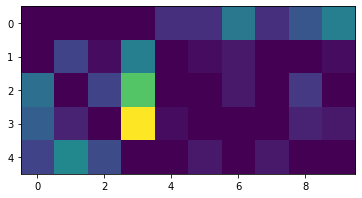

In [252]:
plt.imshow(M_days[0])

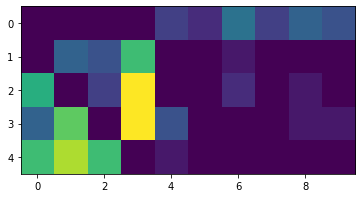

In [257]:
plt.imshow(M_days[1])

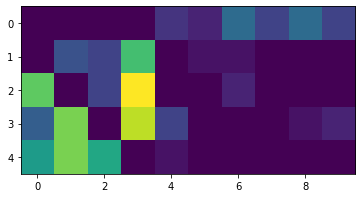

In [169]:
plt.imshow(M_days[1])

In [113]:
Model_M=np.zeros((4,4))
Seq2=[3,4,2,1]
for i in range(len(Seq2)):
    Model_M[Seq2[i]-1,Seq2[i-1]-1]+=1
    Model_M[Seq2[i]-1,Seq2[(i+1)%4]-1]+=1

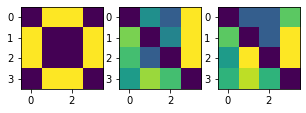

In [120]:
fig,axes=plt.subplots(nrows=1,ncols=len(M_days)+1,figsize=(5,10))
axes[0].imshow(Model_M)
for M_ind in range(len(M_days)):
    axes[M_ind+1].imshow(M_days[M_ind],vmax=20)

In [134]:
nwb_copy_file_name='eliot20221025_.nwb'
epoch_num=6
M=(TrialChoiceDispersedReplay & {'nwb_file_name':nwb_copy_file_name,
                                 'epoch':epoch_num}).fetch1('coactivation_matrix')

In [137]:
M

array([[ 0.,  2.,  3.,  4.],
       [ 1.,  0.,  2.,  7.],
       [ 3.,  7.,  0., 11.],
       [ 0.,  8.,  2.,  0.]])

# END HERE

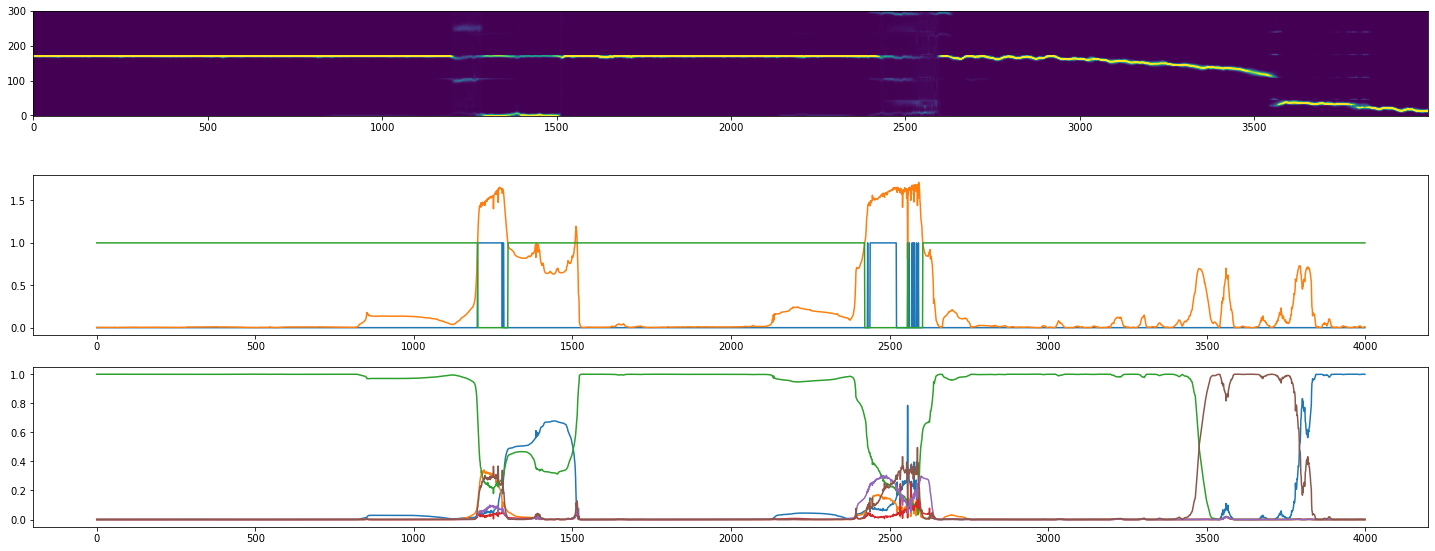

In [184]:
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(25,10))
axes[0].imshow(posterior_position.T,vmax=0.1,origin='lower')

axes[1].plot(f1)
axes[1].plot(H)
axes[1].plot(f_closed)
#plt.plot(all_labels,'*')

axes[2].plot(posterior_arms.T)

In [85]:
t=8
t_home=log_df.loc[t,'timestamp_H']
t_outer=log_df.loc[t,'timestamp_O']
if t+1<len(log_df):
    t_end=log_df.loc[t+1,'timestamp_H']
else:
    t_end=log_df.loc[t,'timestamp_H']+10
    
# ''' HOME '''
# # find times close to home well
# current_location = node_location['home']
# 

''' OUTER '''
# find times close to outer
wellnum=int(log_df.loc[t,'OuterWellIndex'])
current_location = node_location['well'+str(wellnum)]

close_ind=np.abs(linear_position_xr.linear_position-current_location)<10

# find times that is immbile

immobile_ind=headspeed_xr.head_speed<5

'''Mean Posterior across time when animal is at home & immobile'''
t0=t_outer-3
t1=t_outer+10
mask_time = ((decode.time >= t0) 
             & (decode.time < t1)
             & close_ind & immobile_ind)

(arm_start,arm_end)=(linear_map[2*wellnum+1,0],linear_map[2*wellnum+1,1]) #2*wellnum+1 is due to linear map order
        
remote_times=find_remote_times(decode,arm_start,arm_end,mask_time,delta_t=0.01)



In [101]:
len(close_ind)

863240

In [72]:
linear_position_xr=xr.Dataset.from_dataframe(linear_position_df)
position_info_upsample = interpolate_to_new_time(head_speed, np.array(linear_position_xr.time))
headspeed_xr=xr.Dataset.from_dataframe(position_info_upsample)

In [89]:
remote_times

array([[1.66663501e+09, 1.66663501e+09],
       [1.66663501e+09, 1.66663501e+09],
       [1.66663501e+09, 1.66663501e+09]])

In [183]:
df=pd.DataFrame((TrialChoiceRemoteReplay & {'nwb_file_name': nwb_copy_file_name,
                           'epoch_name':'02_Seq2Session2'}).fetch1('choice_reward_replay'))
df

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,remote_H,remote_O,replay_H,replay_O,peak_ripple_H,peak_ripple_O,current,future_H,future_O,past,past_reward
1,NaN,NaN,1.666635e+09,2.0,1.0,[],"[[1666634826.1662393, 1666634826.2722392], [16...",[],"[[], [nan, nan, 1.0, 2.0, nan, 5.0, 4.0]]",[],"[[], (nan, nan)]",2.0,2.0,1.0,NaN,NaN
2,1.666635e+09,1.0,1.666635e+09,1.0,2.0,"[[1666634836.7842376, 1666634837.0942376]]","[[1666634853.002235, 1666634853.228235], [1666...","[[3, 3]]","[[0.0, nan], [nan, 0.0, 0.0], [nan]]","[(nan, nan)]","[(nan, nan), (nan, nan), (nan, nan)]",1.0,1.0,3.0,2.0,NaN
3,1.666635e+09,1.0,1.666635e+09,3.0,2.0,"[[1666634869.6282322, 1666634869.8482323], [16...",[],"[[3, 3], [4], [nan], [], [nan], [], [], [nan],...",[],"[(nan, nan), (nan, nan), (nan, nan), [], (nan,...",[],3.0,3.0,4.0,1.0,1.0
4,1.666635e+09,1.0,1.666635e+09,4.0,2.0,"[[1666634898.9802277, 1666634899.1302276], [16...","[[1666634912.5062256, 1666634912.5362256], [16...","[[1], [5]]","[[nan], [], [2.0, nan, 5.0, 3.0], [nan], [1, 0]]","[(nan, nan), (nan, nan)]","[(nan, nan), [], (nan, nan), (nan, nan), (nan,...",4.0,4.0,2.0,3.0,3.0
5,1.666635e+09,1.0,1.666635e+09,2.0,2.0,"[[1666634933.1022222, 1666634933.4762223], [16...",[],"[[2], [1.0, nan, 1.0]]",[],"[(nan, nan), (nan, nan)]",[],2.0,2.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1.666636e+09,1.0,1.666636e+09,4.0,2.0,"[[1666636392.853991, 1666636393.1959908]]","[[1666636412.3659878, 1666636412.4739878]]","[[nan, 5.0, nan]]",[[1]],"[(nan, nan)]","[(nan, nan)]",4.0,4.0,2.0,1.0,3.0
74,1.666636e+09,1.0,1.666636e+09,2.0,2.0,[],[],[],[],[],[],2.0,2.0,1.0,4.0,4.0
75,1.666636e+09,1.0,1.666636e+09,1.0,2.0,"[[1666636444.3879828, 1666636444.4939828]]",[],[[nan]],[],"[(nan, nan)]",[],1.0,1.0,3.0,2.0,2.0
76,1.666636e+09,1.0,1.666636e+09,3.0,2.0,"[[1666636466.2979794, 1666636466.3159792]]","[[1666636480.5719771, 1666636480.593977]]",[[]],[[]],[[]],[[]],3.0,3.0,4.0,1.0,1.0


8


Text(0.5, 1.0, 'animal head speed')

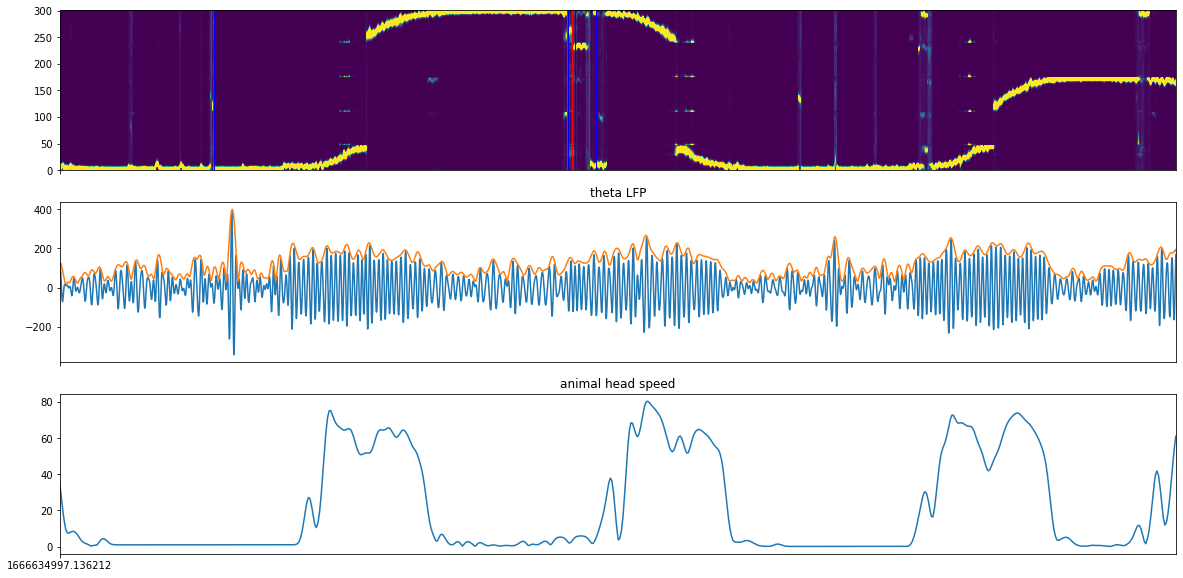

In [338]:
t=8
print(t)

t0=df.loc[t,'timestamp_O']-10
t1=df.loc[t,'timestamp_O']+20
h=headspeed_lfp_xr.sel(time=slice(t0,t1))
close_ind=np.abs(linear_position_xr.sel(time=slice(t0,t1)).linear_position-current_location)<10

mask_time = ((decode.time >= t0) & (decode.time < t1))

acausal_posterior=decode.isel(time=mask_time).acausal_posterior
time=np.array(acausal_posterior.time)
mean_location=np.matmul(np.array(acausal_posterior.sum(dim='state')),np.arange(acausal_posterior.position.size))
max_location=acausal_posterior.sum(dim='state').argmax(dim='position')
    
f,axes=plt.subplots(nrows=3,ncols=1,figsize=(20,10),sharex=True)

x_axis=np.arange(time[0],time[-1],100)
axes[0].imshow(acausal_posterior.sum(dim='state').T,extent=(time[0],time[-1],0,301),vmax=0.02,origin='lower')
axes[0].set_xticks(x_axis, x_axis)
axes[0].set_aspect('auto')

#axes.plot(mean_location,color='red',alpha=0.2)


#axes[0].plot(time,max_location,color='white',alpha=1,linewidth=0.5)
#axes[1].plot(np.array(h.time),close_ind*10)

remote_H=df.loc[t,'remote_H']
remote_O=df.loc[t,'remote_O']
if len(remote_H)>0 and len(remote_O)>0:
    remote_times=np.concatenate((remote_H,remote_O))
if len(remote_times)>0:
    for r in remote_times:
        axes[0].axvline(r[0],color='r',linewidth=1)
        axes[0].axvline(r[-1],color='b',linewidth=1)
    
t_ind = np.argwhere(np.logical_and(theta_timestamps >= t0,
                                          theta_timestamps < t1)).ravel()
theta_d = theta_data[t_ind,:].astype('int32')
theta_t = theta_timestamps[t_ind]

#for e in range(0,np.shape(theta_d)[1],10):
#    axes[1].plot(theta_t,theta_d[:,e])
axes[1].plot(theta_t,np.mean(theta_d,axis=1))
axes[1].plot(theta_t,np.mean(get_envelope(theta_d),axis=1))
axes[1].set_title('theta LFP')

axes[2].plot(np.array(h.time),np.array(h.head_speed))
axes[2].set_title('animal head speed')

### Look into the relationship between Theta and speed

In [351]:
epoch_name = '02_Seq2Session2'
epoch_pos_name = 'pos 1 valid times'

'pos 1 valid times'

In [352]:
t=8

df=pd.DataFrame((TrialChoiceRemoteReplay & {'nwb_file_name': nwb_copy_file_name,
                                            'epoch_name':epoch_name}).fetch1('choice_reward_replay'))

# choose 300 seconds 
t0=df.loc[t,'timestamp_O']-100
t1=df.loc[t,'timestamp_O']+200

# theta, load data from LFPBand table
theta_nwb=(LFPBand & {'nwb_file_name': nwb_copy_file_name,
            'target_interval_list_name':epoch_name,
            'filter_name':'Theta 5-11 Hz pass, 4.5-12 Hz stop'}).fetch_nwb()

theta_data=theta_nwb[0]['filtered_data'].data
theta_timestamps=np.array(theta_nwb[0]['filtered_data'].timestamps)
    
t_ind = np.argwhere(np.logical_and(theta_timestamps >= t0,
                                          theta_timestamps < t1)).ravel()
theta_d = theta_data[t_ind,:].astype('int32')
theta_t = theta_timestamps[t_ind]

# head speed data
position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                        'interval_list_name': epoch_pos_name}).fetch1('valid_times')

position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                                           'interval_list_name': epoch_pos_name,
                                           'position_info_param_name': 'default'}).fetch1_dataframe()

position_info = pd.concat(
    [position_info.loc[slice(valid_time[0], valid_time[1])]
     for valid_time in position_valid_times], axis=0)

head_speed=pd.DataFrame(position_info['head_speed'])
    
head_speed_lfp = interpolate_to_new_time(head_speed, theta_timestamps)
headspeed_lfp_xr=xr.Dataset.from_dataframe(head_speed_lfp)

h=headspeed_lfp_xr.sel(time=slice(t0,t1))

In [360]:
# ripple, load data from LFPBand table
ripple_nwb=(LFPBand & {'nwb_file_name': nwb_copy_file_name,
            'target_interval_list_name':epoch_name,
            'filter_name':'Ripple 150-250 Hz'}).fetch_nwb()

ripple_data=ripple_nwb[0]['filtered_data'].data
ripple_timestamps=np.array(ripple_nwb[0]['filtered_data'].timestamps)
    
t_ind = np.argwhere(np.logical_and(ripple_timestamps >= t0,
                                          ripple_timestamps < t1)).ravel()
ripple_d = ripple_data[t_ind,:].astype('int32')
ripple_t = ripple_timestamps[t_ind]

Text(0.5, 0, 'ripple band envelope power')

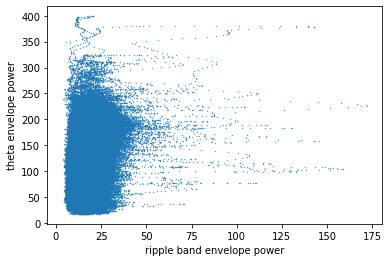

In [371]:
plt.scatter(np.mean(get_envelope(ripple_d),axis=1),np.mean(get_envelope(theta_d),axis=1),s=0.1)
plt.ylabel('theta envelope power')
plt.xlabel('ripple band envelope power')

Text(0, 0.5, 'ripple envelope power')

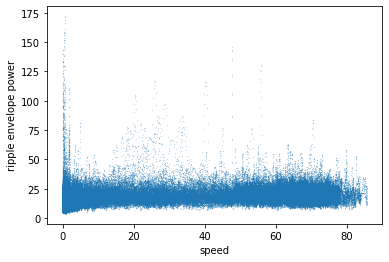

In [372]:
plt.scatter(np.array(h.head_speed),np.mean(get_envelope(ripple_d),axis=1),s=0.01)
plt.xlabel('speed')
plt.ylabel('ripple envelope power')

AttributeError: 'Axes3DSubplot' object has no attribute 'xlabel'

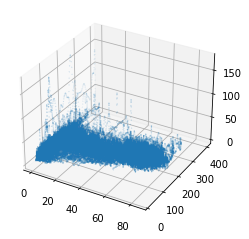

In [378]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.array(h.head_speed),
            np.mean(get_envelope(theta_d),axis=1),
            np.mean(get_envelope(ripple_d),axis=1),s=0.01)
plt.xlabel('speed')
plt.ylabel('theta envelope power')

In [ ]:
plt.scatter(np.array(h.head_speed),np.mean(get_envelope(theta_d),axis=1),s=0.01)

In [22]:
def find_ripple_classify_decode(log_df,linear_map,
                                node_location,home,
                                linear_position_df,linear_position_xr,head_speed_xr,
                                ripple_times,decode,recordings,neural_ts, #spiking data
                                ripple_nwb,ripple_timestamps,
                                mua,mua_time,mua_threshold,
                                exampledir,
                                t,simple=True):

    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    if home:
        ''' HOME '''
        # find times close to home well
        current_location = node_location['home']
    else:
        ''' OUTER '''
        # find times close to outer
        wellnum=int(log_df.loc[t,'OuterWellIndex'])
        current_location = node_location['well'+str(wellnum)]
    close_ind=np.abs(linear_position_xr.linear_position-current_location)<5

    # find times that is immbile
    immobile_ind=head_speed_xr.head_speed<5

    '''Mean Posterior across time when animal is at home & immobile'''
    if home:
        (t0,t1)=(t_home-3,t_outer)
        (arm_start,arm_end)=(linear_map[0,0],linear_map[0,1])
        name_sub='_home_'
    else:
        (t0,t1)=(t_outer-3,t_end)
        (arm_start,arm_end)=(linear_map[2*wellnum+1,0],linear_map[2*wellnum+1,1]) #2*wellnum+1 is due to linear map order
        name_sub='_outer_'
        
    mask_time = ((decode.time >= t0) 
                 & (decode.time < t1)
                 & close_ind & immobile_ind)
    
    if np.array(mask_time.sum())==0:
        print('trial failed:',t)
        return [],[],[],[],[],[]
    
    remote_times=find_remote_times(decode,arm_start,arm_end,mask_time,delta_t=0.01)
    
    # remove those replays without mua above the mean
    print(mua_threshold)
    remote_H_=mua_thresholder(remote_times,mua,mua_time,mua_threshold)
    
    # ripple size
    #ripple_H_=find_ripple_times(remote_times,t_home_start,t_home_end)
    
    # segment ripple
    # unsegmented is "ripple_H_", segmented is called "cont_ripple_H" or "frag_ripple_H"
    cont_remote_H,frag_remote_H=segment_ripples(decode,remote_H_)
    
    # classify into arms, Home well replay, only for continuous replays
    cont_replay_H=classify_ripples(decode,cont_remote_H)
    
    assert len(cont_remote_H)==len(cont_replay_H)
    
    # sort
    remote_H,replay_H=sort_replays(cont_remote_H,frag_remote_H,cont_replay_H)
    
    peak_H=[]
    '''plot each ripple at home, meanwhile find peak'''
    
    for i in range(len(remote_H_)):
        if len(remote_H[i])==0:
            peak_H.append([])
            continue
        peaks=plot_decode_spiking(remote_H_[i],    #ripple start and end time
                            linear_position_df,
                            decode, #decode result
                            recordings,neural_ts, #spiking data
                            ripple_nwb,ripple_timestamps,#ripple
                            offset=1, #2 second window
                            savefolder=exampledir,
                            title='classified as: arm '+str(replay_H[i]),
                            savename='trial'+str(t)+name_sub+str(i+1),
                            simple=simple)
        peak_H.append(peaks)
    
        
    return remote_H_,replay_H,peak_H

In [23]:
def add_replay(epoch_num):
    # RUN THIS CELL AFTER CHANGING FILE
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name+'_contentBased')
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'remote_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'remote_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(9,'peak_ripple_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(10,'peak_ripple_O',[[] for i in range(len(log_df))])

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)
    

    # 5. find MUA threshold immobility times position
    position_info_param_name = 'default'
    position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                            'interval_list_name': epoch_pos_name}).fetch1('valid_times')

    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': position_info_param_name}).fetch1_dataframe()

    position_info = pd.concat(
        [position_info.loc[slice(valid_time[0], valid_time[1])]
         for valid_time in position_valid_times], axis=0)

    head_speed=pd.DataFrame(position_info['head_speed'])
    position_info_upsample = interpolate_to_new_time(head_speed, mua_time)
    imobility_ind=position_info_upsample['head_speed']<=5 #
    mua_threshold=np.mean(mua[imobility_ind])
    

    # find legal trials
    rewardNum=np.array(log_df.rewardNum)
    legal_trials=(np.argwhere(np.logical_and(rewardNum[1:]>=1,rewardNum[:-1]>=1))+1).ravel()

    trial_ind=np.array(log_df.index)
    
    linear_position_xr=xr.Dataset.from_dataframe(linear_position_df)
    position_info_upsample = interpolate_to_new_time(head_speed, np.array(linear_position_xr.time))
    headspeed_xr=xr.Dataset.from_dataframe(position_info_upsample)
    
    '''
    here the actual work gets done
    '''
    for t in legal_trials:
        print('trial',t)
        results=find_ripple_classify_decode(log_df,linear_map,
                                            node_location,True,
                                            linear_position_df,linear_position_xr,headspeed_xr,
                                            ripple_times,decode,recordings,neural_ts, #spiking data
                                            ripple_nwb,ripple_timestamps,
                                            mua,mua_time,mua_threshold,
                                            exampledir,
                                            t)
        # add to the choice_reward_replay
        log_df_replay.at[t, 'remote_H']= results[0]
        log_df_replay.at[t, 'replay_H']= results[1]
        log_df_replay.at[t,'peak_ripple_H']= results[2] #in std
        
        results=find_ripple_classify_decode(log_df,linear_map,
                                            node_location,False, #the False is for not home
                                            linear_position_df,linear_position_xr,headspeed_xr,
                                            ripple_times,decode,recordings,neural_ts, #spiking data
                                            ripple_nwb,ripple_timestamps,
                                            mua,mua_time,mua_threshold,
                                            exampledir,
                                            t)
        log_df_replay.at[t, 'remote_O']=results[0]
        log_df_replay.at[t, 'replay_O']= results[1]
        log_df_replay.at[t,'peak_ripple_O']= results[2]
    
    print('Done parsing. Insert into Spyglass')
    log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()
    
    # insert into Spyglass
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
    TrialChoiceRemoteReplay().make(key,replace=True)